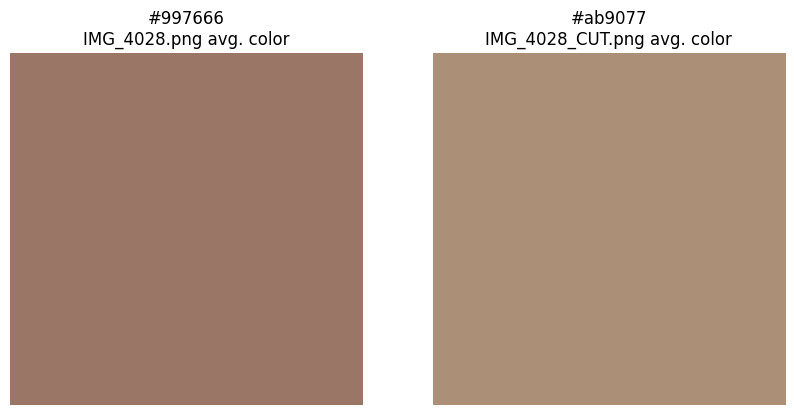

In [16]:
from PIL import Image
import numpy as np
import cv2

# Load the images
image_paths = ["./images/IMG_4028.png", "./images/IMG_4028_CUT.png"]  # Add more image paths as needed
images = [Image.open(image_path) for image_path in image_paths]

average_colors = []
average_colors_hex = []

for image in images:
    # Convert the image to OpenCV format and then to grayscale
    image_cv = np.array(image)
    gray_image = cv2.cvtColor(image_cv, cv2.COLOR_RGB2GRAY)

    # Apply a binary threshold to remove reflections (assuming reflections are the brightest spots)
    _, thresholded_image = cv2.threshold(gray_image, 200, 255, cv2.THRESH_BINARY_INV)

    # Create a mask using the thresholded image
    mask = thresholded_image > 0

    # Calculate the average color value of the non-reflection areas
    teeth_pixels = image_cv[mask]

    # Calculate the average RGB value
    average_color = np.mean(teeth_pixels, axis=0)

    # Ensure the color values are integers
    average_color_int = average_color.astype(int)

    # Convert to hex
    average_color_hex = '#%02x%02x%02x' % tuple(average_color_int[:3])

    # Store the results
    average_colors.append(average_color)
    average_colors_hex.append(average_color_hex)

average_colors
average_colors_hex

# Visually show the hex colors and the original images
import matplotlib.pyplot as plt

fig, ax = plt.subplots(2, len(images), figsize=(10, 10))
for i, (color, hex_color, image_path, image) in enumerate(zip(average_colors, average_colors_hex, image_paths, images)):
    # Show the original image
    ax[0, i].imshow(image)
    ax[0, i].set_title(f"Original Image\n{image_path.split('/')[-1]}")
    ax[0, i].axis('off')
    
    # Show the average color
    ax[1, i].imshow(np.array([[color]], dtype=np.uint8))
    ax[1, i].set_title(f"{hex_color}\n{image_path.split('/')[-1]} avg. color")
    ax[1, i].axis('off')

plt.show()